In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyrheautils as pu
from collections import deque, defaultdict
from facilitybase import CareTier
from tools_util import readModelInputs, getFacDict


In [3]:
#df = pd.read_msgpack('/home/welling/sshfshook/Chi_crebundle_baseline_233_dataframe.mpz')
df = pd.read_msgpack('/home/welling/sshfshook/baseline_special/Chi_crebundle_baseline_special_olym2_dataframe.mpz')


In [4]:
print df.columns

Index([u'index', u'abbrev', u'day', u'tier', u'xdroCPDays', u'otherCPDays',
       u'CHRONIC', u'CLEAR', u'COLONIZED', u'INFECTED', u'RECOVERED',
       u'UNDETCOLONIZED', u'creArrivals', u'creBundlesHandedOut', u'arrivals',
       u'swabCPDays', u'contactPrecautionDays', u'newColonized',
       u'passiveCPDays', u'creSwabsUsed', u'newPatientsOnCP', u'run'],
      dtype='object')


In [6]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_ChicagoLand.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)

totD = defaultdict(int)
nFacD = defaultdict(int)
for fac, rec in facDict.items():
    nFacD[rec['category']] += 1
    totD[rec['category']] += rec['meanPop']['value']
print 'totD: ', totD
print 'nFacD: ', nFacD


totD:  defaultdict(<type 'int'>, {'SNF': 44029.96048152038, 'HOSPITAL': 13839.558332146706, 'VSNF': 2359.043835616, 'COMMUNITY': 9082963, 'LTACH': 528.550274452})
nFacD:  defaultdict(<type 'int'>, {'SNF': 351, 'HOSPITAL': 90, 'VSNF': 12, 'COMMUNITY': 2260, 'LTACH': 9})


In [7]:
perFacDF=df.groupby(['day', 'abbrev', 'tier']).sum().reset_index()
print perFacDF

          day         abbrev     tier     index  xdroCPDays  otherCPDays  \
0           1      ABBI_31_S  NURSING         0         0.0          2.0   
1           1     ADAM_119_S  NURSING      2999         0.0          2.0   
2           1     ADVE_120_H     HOSP     11997         0.0         32.0   
3           1     ADVE_120_H      ICU     71991         0.0         72.0   
4           1     ADVE_500_H     HOSP     59981         0.0         28.0   
5           1     ADVE_500_H      ICU    215943         0.0         24.0   
6           1    ADVE_5101_H     HOSP    107965         0.0         44.0   
7           1    ADVE_5101_H      ICU    359895         0.0        108.0   
8           1     ADVE_701_H     HOSP    155949         0.0         40.0   
9           1     ADVE_701_H      ICU    503847         0.0         36.0   
10          1    ADVO_1775_H     HOSP    203933         0.0        128.0   
11          1    ADVO_1775_H      ICU    647799         0.0        132.0   
12          

In [8]:
def roundUp(val, wardSz):
    nWards = (val//wardSz)
    if nWards*wardSz < val:
        nWards += 1
    return nWards*wardSz

def getNBeds(row, facDict=facDict):
    rec = facDict[row['abbrev']]
    bedScale = 1.2
    if rec['category'] in ['SNF', 'NURSINGHOME']:
        if row['tier'] == 'NURSING':
            return bedScale*rec['nBeds']['value']
        else:
            return 0.0
    elif rec['category'] == 'HOSPITAL':
        if row['tier'] == 'HOSP':
            return roundUp(bedScale*(rec['nBeds']['value'] - rec['nBedsICU']['value']),
                           20)
        elif row['tier'] == 'ICU':
            return roundUp(bedScale*rec['nBedsICU']['value'],
                           20)
        else:
            return 0.0
    elif rec['category'] in ['LTAC', 'LTACH']:
        if row['tier'] == 'LTAC':
            return roundUp(bedScale*rec['nBeds']['value'],
                           20)
        else:
            return 0.0
    else:
        return 0.0

nBedV = perFacDF.apply(getNBeds, axis=1, facDict=facDict)
perFacDF['nBeds'] = nBedV

In [9]:
print perFacDF.loc[perFacDF['day']==2000]

          day         abbrev     tier     index  xdroCPDays  otherCPDays  \
1149425  2000      ABBI_31_S  NURSING      1999         0.0          0.0   
1149426  2000     ADAM_119_S  NURSING      4998         0.0          0.0   
1149427  2000     ADVE_120_H     HOSP     19993         0.0         70.0   
1149428  2000     ADVE_120_H      ICU    143955         0.0         66.0   
1149429  2000     ADVE_500_H     HOSP     67977         0.0         44.0   
1149430  2000     ADVE_500_H      ICU    287907         0.0         18.0   
1149431  2000    ADVE_5101_H     HOSP    115961         0.0         38.0   
1149432  2000    ADVE_5101_H      ICU    431859         0.0         12.0   
1149433  2000     ADVE_701_H     HOSP    163945         0.0         34.0   
1149434  2000     ADVE_701_H      ICU    575811         0.0         42.0   
1149435  2000    ADVO_1775_H     HOSP    211929         0.0        200.0   
1149436  2000    ADVO_1775_H      ICU    719763         0.0         18.0   
1149437  200

In [10]:
def calcTotPop(df, suffix=''):
    
    return (df['CHRONIC'+suffix] + df['CLEAR'+suffix] + df['COLONIZED'+suffix]
            + df['INFECTED'+suffix] + df['RECOVERED'+suffix] + df['UNDETCOLONIZED'+suffix])
perFacDF['totPop'] = calcTotPop(perFacDF)
perFacDF['freeBeds'] = perFacDF['nBeds'] - perFacDF['totPop']

In [11]:
perFacDF.drop('index', axis=1)
print perFacDF.loc[perFacDF['day']==2000][['abbrev','tier','totPop','nBeds','freeBeds']]

                abbrev     tier  totPop  nBeds  freeBeds
1149425      ABBI_31_S  NURSING    60.0   90.0      30.0
1149426     ADAM_119_S  NURSING    45.0   66.0      21.0
1149427     ADVE_120_H     HOSP   220.0  220.0       0.0
1149428     ADVE_120_H      ICU    31.0   40.0       9.0
1149429     ADVE_500_H     HOSP   131.0  140.0       9.0
1149430     ADVE_500_H      ICU     4.0   20.0      16.0
1149431    ADVE_5101_H     HOSP   180.0  180.0       0.0
1149432    ADVE_5101_H      ICU     5.0   40.0      35.0
1149433     ADVE_701_H     HOSP   139.0  140.0       1.0
1149434     ADVE_701_H      ICU    20.0   20.0       0.0
1149435    ADVO_1775_H     HOSP   498.0  500.0       2.0
1149436    ADVO_1775_H      ICU     8.0   80.0      72.0
1149437   ADVO_17800_H     HOSP   250.0  260.0      10.0
1149438   ADVO_17800_H      ICU     1.0   40.0      39.0
1149439    ADVO_2320_H     HOSP   193.0  200.0       7.0
1149440    ADVO_2320_H      ICU     8.0   20.0      12.0
1149441    ADVO_3435_L     LTAC

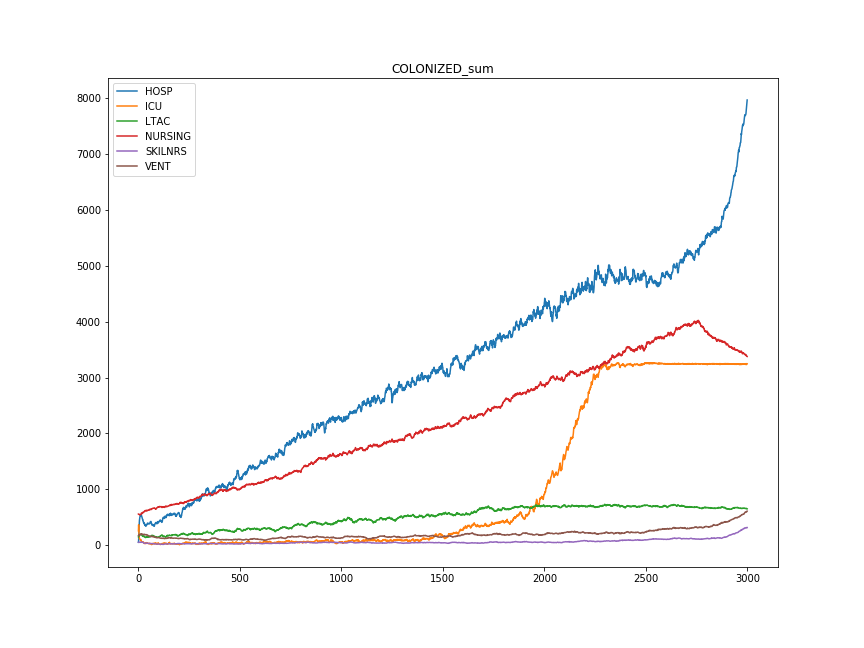

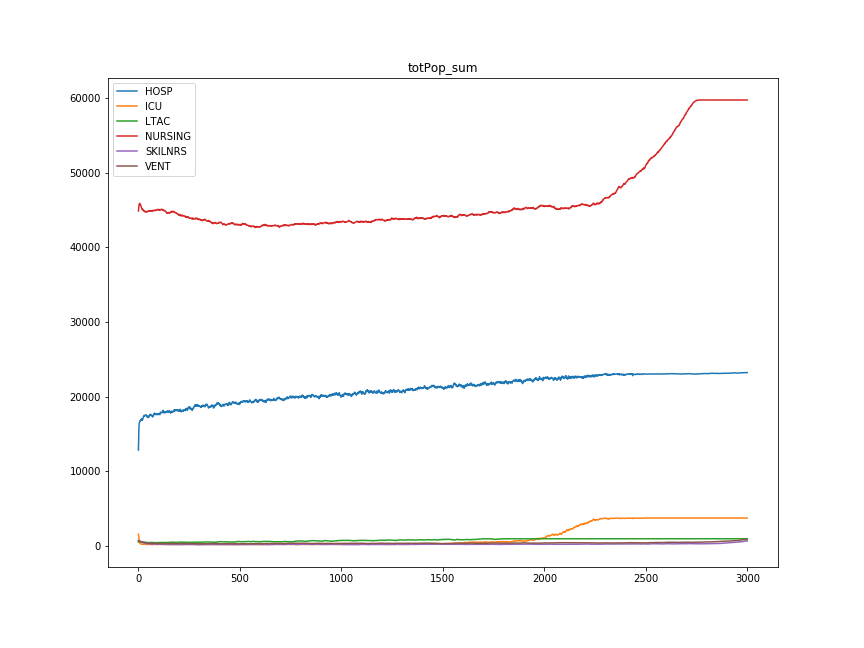

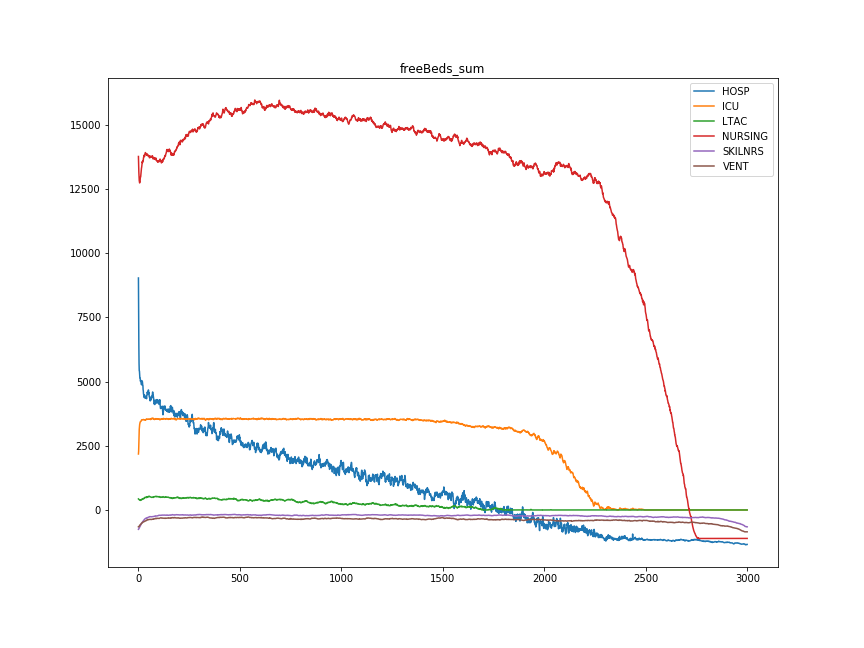

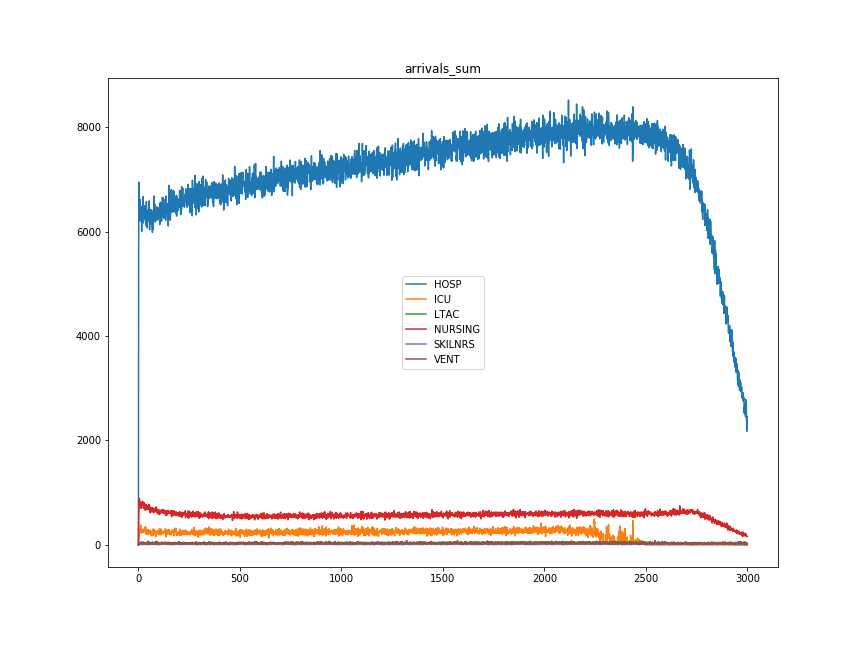

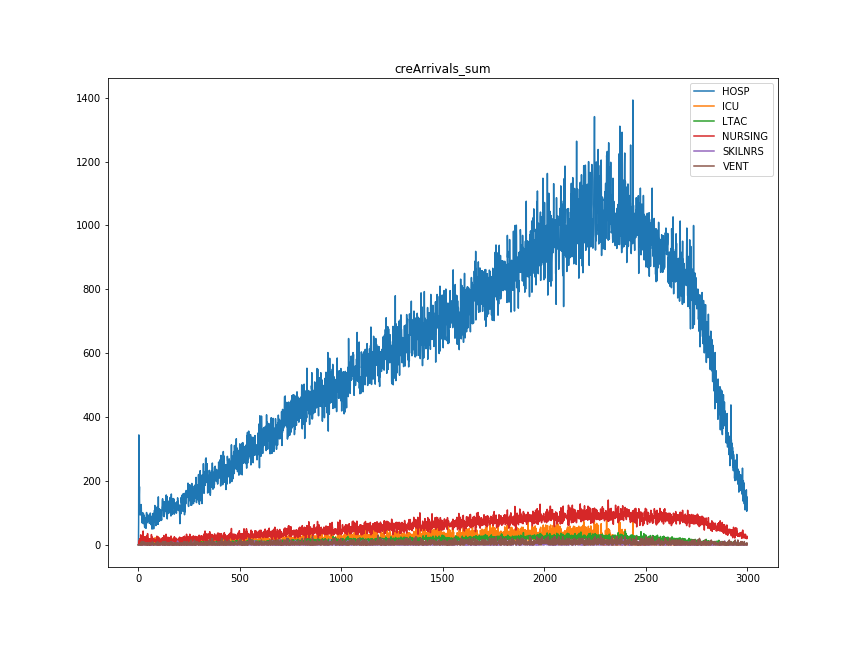

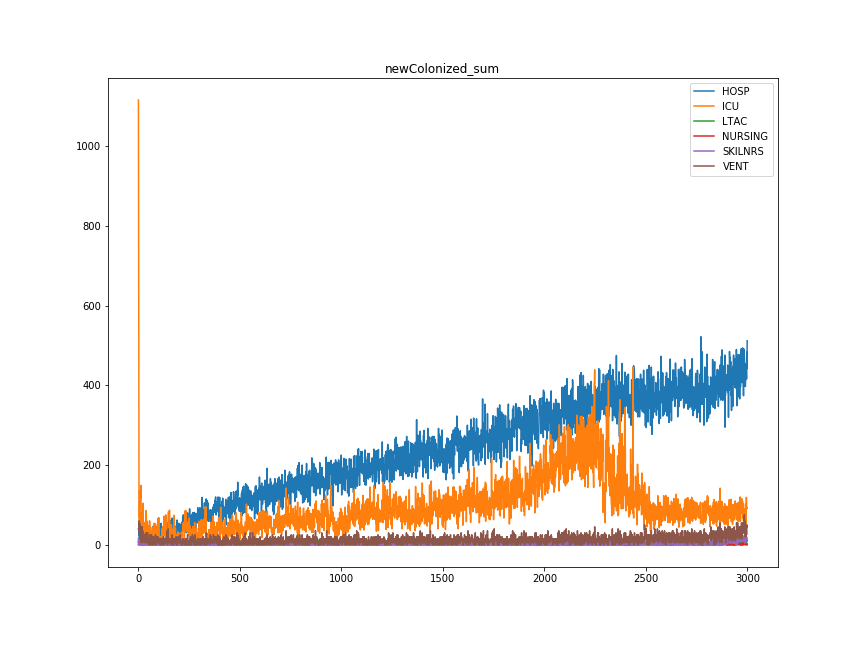

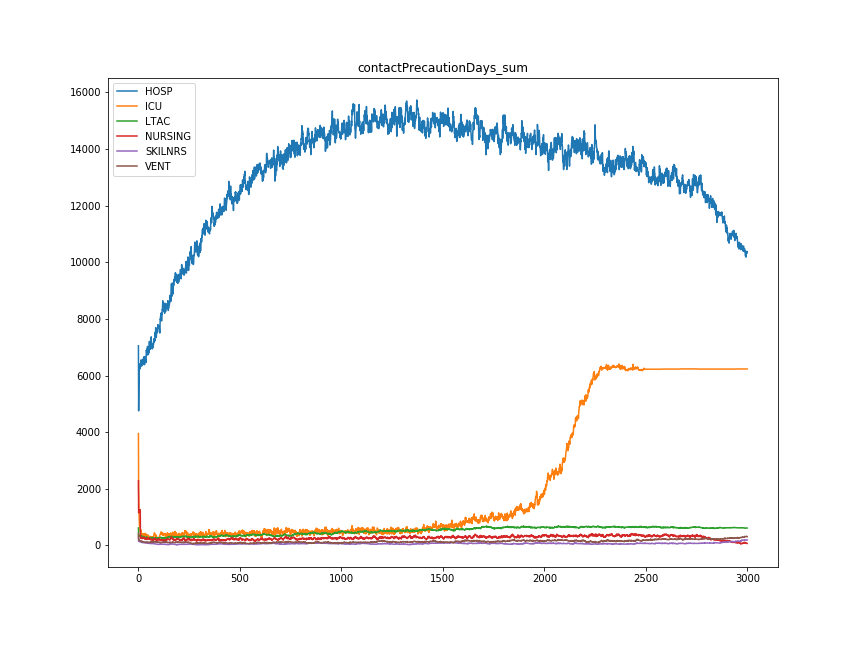

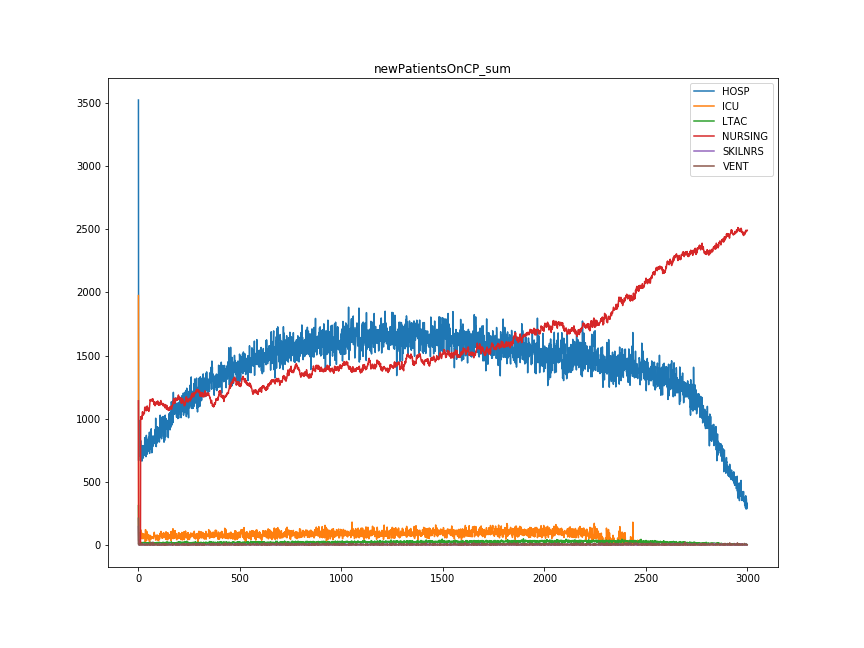

In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]
grp = perFacDF.groupby(['tier', 'day'])
tierSumDF = grp.sum().add_suffix('_sum')
for plotWhat in ['COLONIZED_sum', 'totPop_sum', 'freeBeds_sum', 'arrivals_sum', 'creArrivals_sum', 'newColonized_sum', 'contactPrecautionDays_sum',
                'newPatientsOnCP_sum']:
    fig, axes = plt.subplots(1,1)
    for tier, subgrp in tierSumDF.groupby('tier'):
        subgrp = subgrp.reset_index()
        xV = subgrp['day']
        yV = subgrp[plotWhat]
        #axes.set_yscale('log')
        axes.plot(xV, yV, label=tier)
    axes.legend()
    axes.set_title(plotWhat)
    plt.plot()

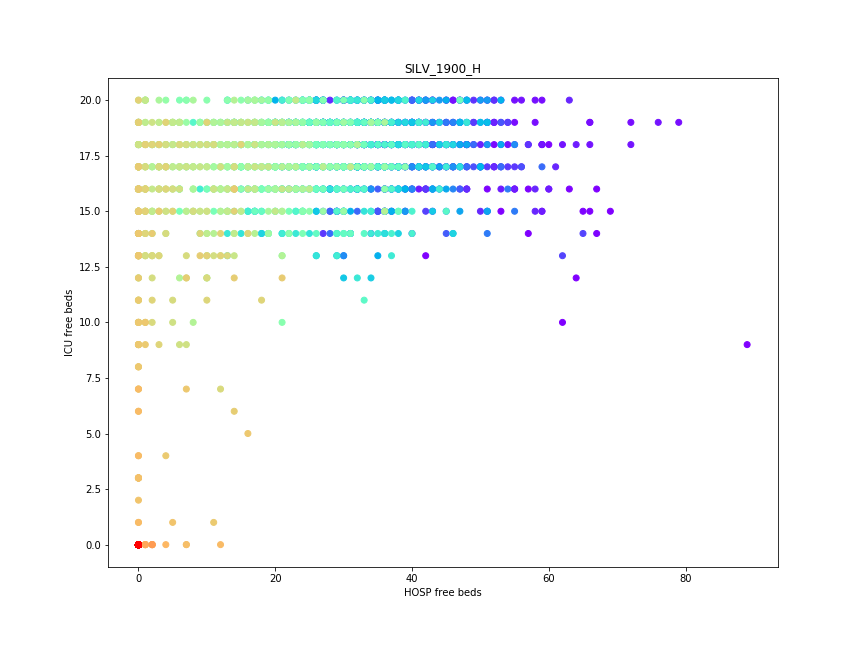

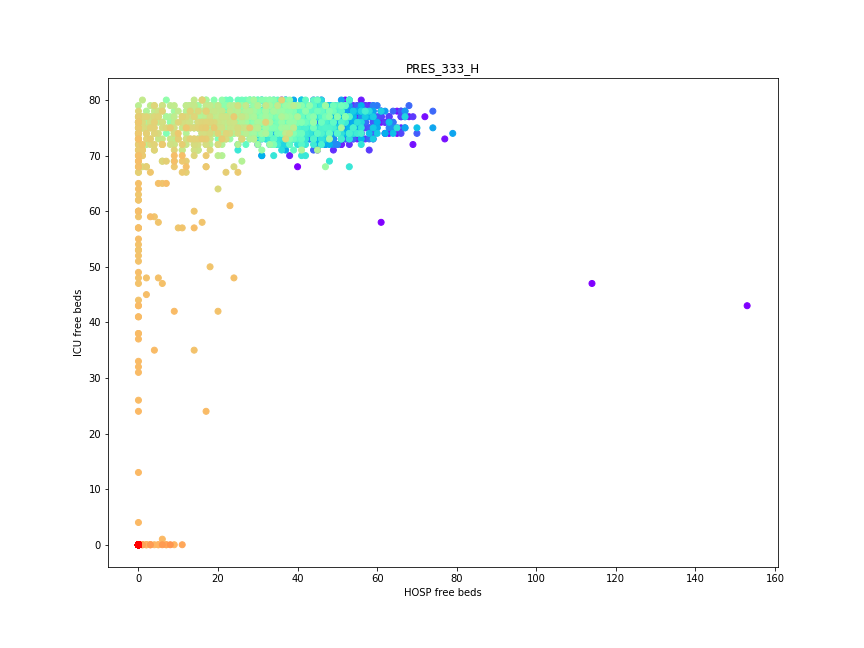

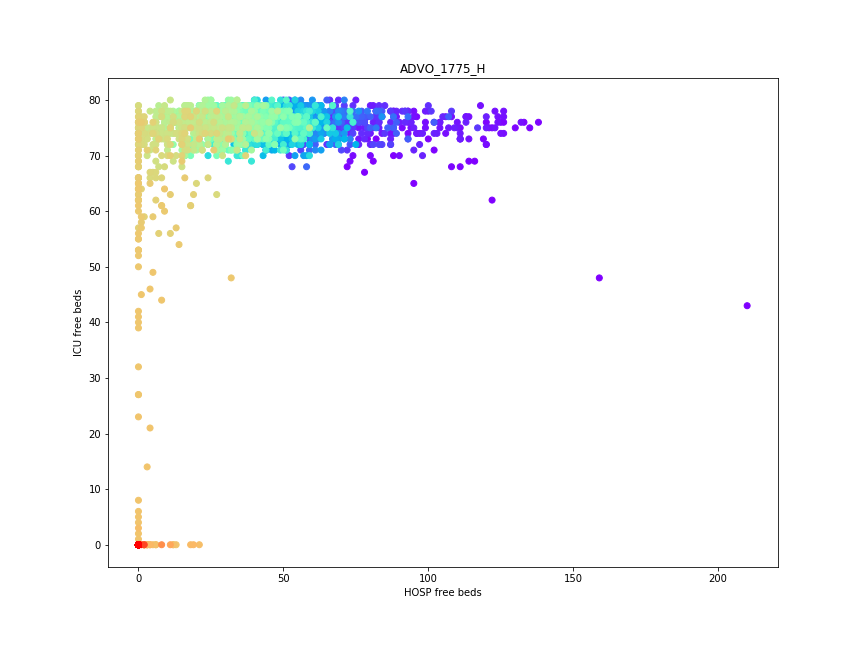

In [13]:
import matplotlib.cm as cm
for fac in ['SILV_1900_H', 'PRES_333_H', 'ADVO_1775_H']:
    hSamps = perFacDF.loc[perFacDF['abbrev'] == fac].loc[perFacDF['tier']=='HOSP'][['day', 'freeBeds']]
    hSamps = hSamps.rename(index=str, columns={'freeBeds':'hFreeBeds'})
                                                                                         
    iSamps = perFacDF.loc[perFacDF['abbrev'] == fac].loc[perFacDF['tier']=='ICU'][['day', 'freeBeds']]
    iSamps = iSamps.rename(index=str, columns={'freeBeds':'iFreeBeds'})

    mergeSamps = hSamps.merge(iSamps, how='inner', left_on='day', right_on='day')
                                                                                         
    #print mergeSamps
    fig, axes = plt.subplots(1, 1)
    clrV = (mergeSamps['day'] - np.min(mergeSamps['day']))/(np.max(mergeSamps['day']) - np.min(mergeSamps['day']))
    axes.scatter(mergeSamps['hFreeBeds'], mergeSamps['iFreeBeds'], c=cm.rainbow(clrV))
    axes.set_title('%s' % fac)
    axes.set_xlabel('HOSP free beds')
    axes.set_ylabel('ICU free beds')
    plt.show()
                                                              

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]
grp = df.groupby(['tier', 'day'])
tierSumDF = grp.sum().add_suffix('_sum')
fig, axes = plt.subplots(1,1)
#plotWhat = 'COLONIZED_sum'
plotWhat = 'newColonized_sum'
for tier, subgrp in tierSumDF.groupby('tier'):
    subgrp = subgrp.reset_index()
    xV = subgrp['day']
    yV = subgrp[plotWhat]
    axes.plot(xV, yV, label=tier)
axes.legend()
axes.set_title(plotWhat)
plt.plot()

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]
grp = df.groupby(['tier', 'day'])
tierSumDF = grp.sum().add_suffix('_sum')
fig, axes = plt.subplots(1,1)
#plotWhat = 'COLONIZED_sum'
plotWhat = 'newPatientsOnCP_sum'
for tier, subgrp in tierSumDF.groupby('tier'):
    subgrp = subgrp.reset_index()
    xV = subgrp['day']
    yV = subgrp[plotWhat]
    axes.plot(xV, yV, label=tier)
axes.legend()
axes.set_title(plotWhat)
plt.plot()

In [ ]:
print df.columns

grpDF = df.groupby(['tier', 'abbrev', 'day']).sum().reset_index()
grpDF = grpDF.loc[grpDF['tier']=='ICU']
plotWhat = 'creArrivals'
fig, axes = plt.subplots(1,1)
for abbrev, subgrp in grpDF.groupby('abbrev'):
    subgrp = subgrp.reset_index()
    xV = subgrp['day']
    yV = subgrp[plotWhat]
    axes.plot(xV, yV+1, label=abbrev)
axes.set_yscale('log')
axes.set_title(plotWhat)
axes.legend()
plt.plot()

In [ ]:
print df.columns

grpDF = df.groupby(['tier', 'abbrev', 'day']).sum().reset_index()
grpDF = grpDF.loc[grpDF['tier']=='HOSP']
fig, axes = plt.subplots(1,1)
for abbrev, subgrp in grpDF.groupby('abbrev'):
    subgrp = subgrp.reset_index()
    xV = subgrp['day']
    yV = subgrp['COLONIZED']
    axes.plot(xV, yV+1, label=abbrev)
axes.set_yscale('log')
axes.legend()
plt.plot()

In [ ]:
print df.columns

grpDF = df.groupby(['tier', 'abbrev', 'day']).sum().reset_index()
grpDF = grpDF.loc[grpDF['tier']=='LTAC']
fig, axes = plt.subplots(1,1)
for abbrev, subgrp in grpDF.groupby('abbrev'):
    subgrp = subgrp.reset_index()
    xV = subgrp['day']
    yV = subgrp['COLONIZED']
    axes.plot(xV, yV+1, label=abbrev)
axes.set_yscale('log')
axes.legend()
plt.plot()

In [ ]:

#fig, axes = plt.subplots(1)

print tierSumDF.columns
tierSumDF.plot(x='day', y='COLONIZED_sum')